In [65]:
import numpy as np
import math
from copy import deepcopy
from typing import List, Callable, Union
import matplotlib.pyplot as plt


In [66]:
def bin_to_float(bitstring: str) -> float:

    if len(bitstring) != 16 or not all(digit in '01' for digit in bitstring):
        raise ValueError("Invalid bitstring length")
    
    int_val = int(bitstring, 2)
    bytes_val = int_val.to_bytes(2, byteorder='big')

    return np.frombuffer(bytes_val, dtype='f2')[0]
    
print(bin_to_float('0000000000000001'))


1.526e-05


In [67]:
def decode_multidim(chromosome: str, dimensions: int) -> List[float]:
    
    if len(chromosome) % dimensions != 0:
        raise ValueError(f"Chromosome length must be divisible by dimensions ({dimensions})")
    
    bits_per_dim = len(chromosome) // dimensions
    
    if bits_per_dim != 16:
        raise ValueError("Each dimension must use 16 bits")
    
    values = []
    for i in range(dimensions):
        start_idx = i * bits_per_dim
        end_idx = start_idx + bits_per_dim
        dim_bits = chromosome[start_idx:end_idx]
        values.append(bin_to_float(dim_bits))
    
    return values


In [68]:
class Qubit():
    superposition_amplitude = 1 / np.sqrt(2)

    def __init__(self, measurement: bool) -> None:
        self.measurement: bool = measurement
        self.alpha: float = self.superposition_amplitude
        self.beta: float = self.superposition_amplitude
        self.superposition: bool = False
        
    def apply_hadamard(self) -> 'Qubit':
        superposition_amplitude = 1 / np.sqrt(2)

        self.alpha = superposition_amplitude
        self.beta = superposition_amplitude
        self.superposition = True
        
        return self
        
    def apply_xgate(self) -> None:
        self.measurement = not self.measurement
        
    def measure(self) -> bool:
        if not self.superposition:
            return self.measurement
        
        random_var = np.random.uniform(0, 1)
        self.measurement = np.pow(self.beta, 2) >= random_var
        self.superposition = False
        
        return self.measurement
    
    def __str__(self) -> str:
        return f'Qubit[superposition: {self.superposition}, [measurement: {self.measurement}]]'


In [69]:
def single_qubit_measurement(qubit: Qubit) -> bool:
    return qubit.measure()

def full_measurement(quantum_chromosome: List[Qubit]) -> str:
    for gene in quantum_chromosome:
        gene.measure()
        
    return ''.join(map(lambda x: str(int(x.measure())), quantum_chromosome))

def crossover(
        queen: List[Qubit],
        male: List[Qubit],
        num_swap_qubits: int
    ) -> str:

    quantum_chromosome = deepcopy(queen)
    random_ind = np.random.randint(0, len(queen) - num_swap_qubits)
    
    for i in range(random_ind, random_ind + num_swap_qubits):
        if queen[i].measure() == male[i].measure():
            quantum_chromosome[i].apply_hadamard()
        else:
            quantum_chromosome[i].apply_xgate()
    
    return full_measurement(quantum_chromosome)

In [70]:
def evolution(
        population_size: int,
        fitness: Callable[[Union[float, List[float]]], float],
        dimensions: int = 1,
        qubits_per_dim: int = 16,
        num_males: int = 20,
        num_elites: int = 20,
        max_iteration: int = 500,
        crossover_size: int = 3,
        maximize: bool = False
    ) -> (Union[float, List[float]], dict, List[str]):
    
    qubits_in_indiv = qubits_per_dim * dimensions
    population = []

    # Initialize the population (each individual is a quantum chromosome)
    for i in range(population_size):
        quantum_chromosome = [Qubit(False).apply_hadamard() for _ in range(qubits_in_indiv)]
        quantum_chromosome_measured = [str(int(qubit.measure())) for qubit in quantum_chromosome]
        new_chromosome = ''.join(quantum_chromosome_measured)
        population.append(new_chromosome)
    
    if dimensions == 1:
        fitness_key = lambda x: fitness(bin_to_float(x))
    else:
        fitness_key = lambda x: fitness(decode_multidim(x, dimensions))
    
    population.sort(key=fitness_key, reverse=maximize)
    
    queen = population[0]
    males = population[1:num_males]
    
    # --- History recording ---
    history = {"iteration": [], "queen_fitness": [], "queen_value": []}
    if dimensions == 1:
        queen_value = bin_to_float(queen)
    else:
        queen_value = decode_multidim(queen, dimensions)
    
    history["iteration"].append(0)
    history["queen_fitness"].append(fitness(queen_value))
    history["queen_value"].append(queen_value)
    # --- End of history recording ---
    
    for iteration in range(max_iteration):
        for i in range(population_size - num_elites, population_size):
            selected_male = males[np.random.randint(0, num_males - 1)]
            population[i] = crossover(
                [Qubit(bool(int(digit))) for digit in queen],
                [Qubit(bool(int(digit))) for digit in selected_male],
                crossover_size
            )
        
        population.sort(key=fitness_key, reverse=maximize)
        queen = population[0]
        males = population[1:num_males]
        
        if dimensions == 1:
            queen_value = bin_to_float(queen)
            current_fitness = fitness(queen_value)
            print(f'Iteration: {iteration + 1}, Queen: {queen_value}, Fitness: {current_fitness}')
        else:
            queen_value = decode_multidim(queen, dimensions)
            current_fitness = fitness(queen_value)
            print(f'Iteration: {iteration + 1}, Queen: {queen_value}, Fitness: {current_fitness}')
        
        # Record the current iteration info into history
        history["iteration"].append(iteration + 1)
        history["queen_fitness"].append(current_fitness)
        history["queen_value"].append(queen_value)
    
    if dimensions == 1:
        return bin_to_float(queen), history, population
    else:
        return decode_multidim(queen, dimensions), history, population


In [71]:
def fitness_first(x: float) -> float:
    return (x - 15) ** 2 

def fitness_second(x: float) -> float:
    if not -5 <= x <= 5:
        return float('inf')  # Penalize out-of-bounds
    
    A = 10
    rastrigin = A + (x**2 - A * math.cos(2 * math.pi * x))
    discontinuity = 50 if -0.1 < x < 0.1 else 0
    noise = np.random.uniform(-0.5, 0.5)
    
    return rastrigin + discontinuity + noise

def deceptive_function(x: float) -> float:

    if not -10 <= x <= 10:
        return float('inf')  # Penalize out-of-bounds
    
    schwefel = 418.9829 - x * math.sin(math.sqrt(abs(x)))
    
    plateau = 100 if -2 <= x <= 2 else 0
    dip = -50 if -0.1 < x < 0.1 else 0
    poly = 0.1 * x**4 - 2 * x**2
    
    return schwefel + plateau + dip + poly


In [72]:
def fitness_first(x: float) -> float:
    return (x - 15) ** 2 

def fitness_second(x: float) -> float:
    if not -5 <= x <= 5:
        return float('inf')  # Penalize out-of-bounds
    
    A = 10
    rastrigin = A + (x**2 - A * math.cos(2 * math.pi * x))
    discontinuity = 50 if -0.1 < x < 0.1 else 0
    noise = np.random.uniform(-0.5, 0.5)
    
    return rastrigin + discontinuity + noise

def deceptive_function(x: float) -> float:

    if not -10 <= x <= 10:
        return float('inf')  # Penalize out-of-bounds
    
    schwefel = 418.9829 - x * math.sin(math.sqrt(abs(x)))
    
    plateau = 100 if -2 <= x <= 2 else 0
    dip = -50 if -0.1 < x < 0.1 else 0
    poly = 0.1 * x**4 - 2 * x**2
    
    return schwefel + plateau + dip + poly


In [73]:
final_value, history, population = evolution(1000, fitness=deceptive_function, dimensions=1)

Iteration: 1, Queen: 3.046875, Fitness: 406.0
Iteration: 2, Queen: 3.234375, Fitness: 405.75
Iteration: 3, Queen: 3.234375, Fitness: 405.75
Iteration: 4, Queen: 3.234375, Fitness: 405.75
Iteration: 5, Queen: 3.234375, Fitness: 405.75
Iteration: 6, Queen: 3.234375, Fitness: 405.75
Iteration: 7, Queen: 3.234375, Fitness: 405.75
Iteration: 8, Queen: 3.234375, Fitness: 405.75
Iteration: 9, Queen: 3.234375, Fitness: 405.75
Iteration: 10, Queen: 3.234375, Fitness: 405.75
Iteration: 11, Queen: 3.234375, Fitness: 405.75
Iteration: 12, Queen: 3.234375, Fitness: 405.75
Iteration: 13, Queen: 3.234375, Fitness: 405.75
Iteration: 14, Queen: 3.234375, Fitness: 405.75
Iteration: 15, Queen: 3.234375, Fitness: 405.75
Iteration: 16, Queen: 3.234375, Fitness: 405.75
Iteration: 17, Queen: 3.234375, Fitness: 405.75
Iteration: 18, Queen: 3.234375, Fitness: 405.75
Iteration: 19, Queen: 3.234375, Fitness: 405.75
Iteration: 20, Queen: 3.234375, Fitness: 405.75
Iteration: 21, Queen: 3.234375, Fitness: 405.75
It

In [74]:
def simple_2d_circle(list_x: List[float]) -> float:
    return np.pow(list_x[0] + 5, 2) + np.pow(list_x[1] + 10, 2)
final_2d, history_2d, population_2d = evolution(1000, fitness=simple_2d_circle, dimensions=2, maximize=False)


C:\Users\user\AppData\Local\Temp\ipykernel_15648\1464993932.py:2: RuntimeWarning: overflow encountered in power
  return np.pow(list_x[0] + 5, 2) + np.pow(list_x[1] + 10, 2)
C:\Users\user\AppData\Local\Temp\ipykernel_15648\1464993932.py:2: RuntimeWarning: invalid value encountered in scalar add
  return np.pow(list_x[0] + 5, 2) + np.pow(list_x[1] + 10, 2)


Iteration: 1, Queen: [np.float16(1.19e-05), np.float16(-9.266)], Fitness: 25.53125
Iteration: 2, Queen: [np.float16(1.19e-05), np.float16(-9.266)], Fitness: 25.53125
Iteration: 3, Queen: [np.float16(1.19e-05), np.float16(-9.484)], Fitness: 25.265625
Iteration: 4, Queen: [np.float16(1.19e-05), np.float16(-9.484)], Fitness: 25.265625
Iteration: 5, Queen: [np.float16(1.19e-05), np.float16(-9.61)], Fitness: 25.15625
Iteration: 6, Queen: [np.float16(1.19e-05), np.float16(-9.61)], Fitness: 25.15625
Iteration: 7, Queen: [np.float16(-2.393), np.float16(-9.61)], Fitness: 6.94921875
Iteration: 8, Queen: [np.float16(-2.393), np.float16(-9.984)], Fitness: 6.796875
Iteration: 9, Queen: [np.float16(-2.393), np.float16(-9.984)], Fitness: 6.796875
Iteration: 10, Queen: [np.float16(-3.893), np.float16(-8.984)], Fitness: 2.2578125
Iteration: 11, Queen: [np.float16(-4.785), np.float16(-8.984)], Fitness: 1.0771484375
Iteration: 12, Queen: [np.float16(-4.785), np.float16(-8.984)], Fitness: 1.0771484375
Ite

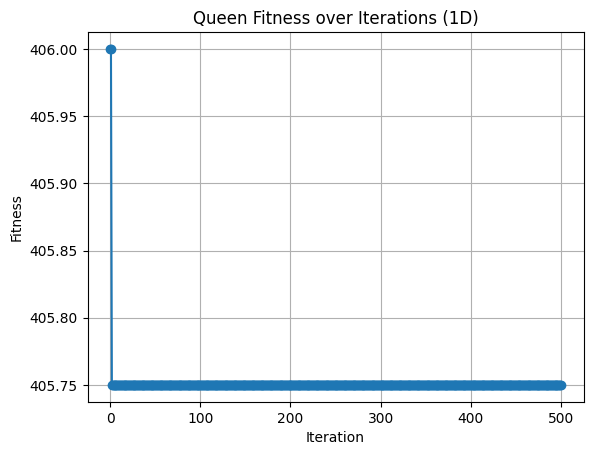

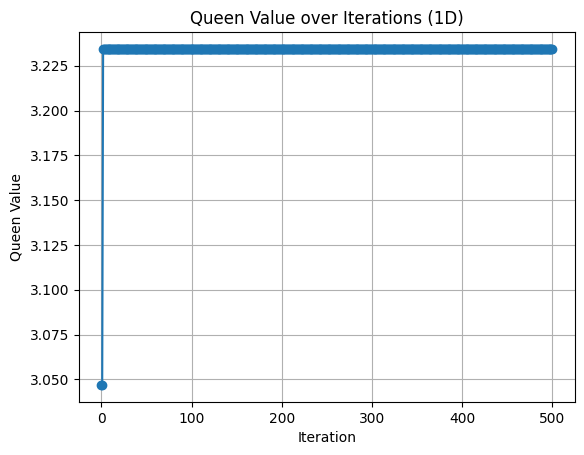

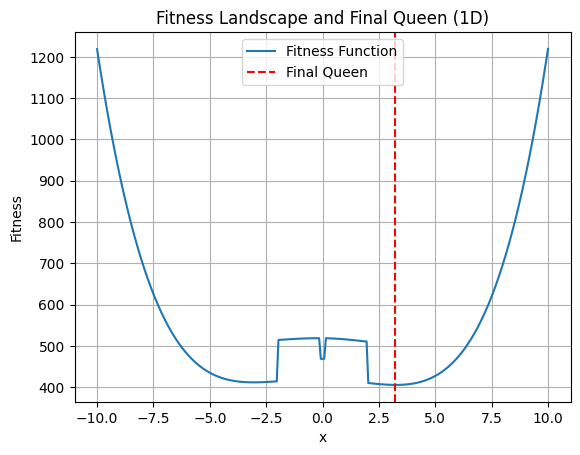

In [76]:
def visualize_1d_evolution(history, population, fitness_func, lower_bound=-20, upper_bound=10):
    # Plot queen fitness over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_fitness"], marker='o')
    plt.title("Queen Fitness over Iterations (1D)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.grid(True)
    
    # Plot queen value over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_value"], marker='o')
    plt.title("Queen Value over Iterations (1D)")
    plt.xlabel("Iteration")
    plt.ylabel("Queen Value")
    plt.grid(True)
    
    # Plot fitness landscape and final queen value
    plt.figure()
    x_vals = np.linspace(lower_bound, upper_bound, 400)
    y_vals = [fitness_func(x) for x in x_vals]
    plt.plot(x_vals, y_vals, label="Fitness Function")
    final_queen = history["queen_value"][-1]
    plt.axvline(final_queen, color='r', linestyle='--', label="Final Queen")
    plt.title("Fitness Landscape and Final Queen (1D)")
    plt.xlabel("x")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    
    plt.show()


visualize_1d_evolution(history, population, deceptive_function, lower_bound=-20, upper_bound=10)


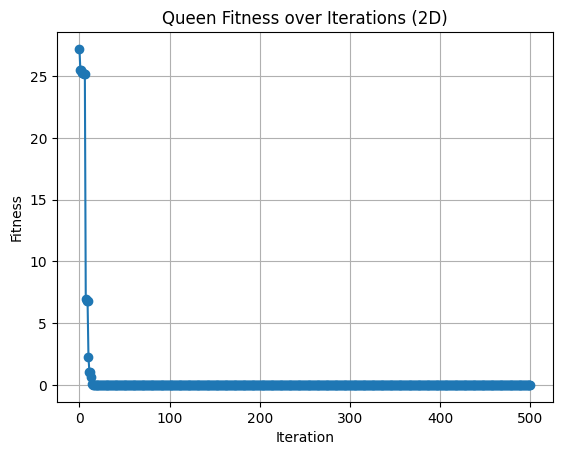

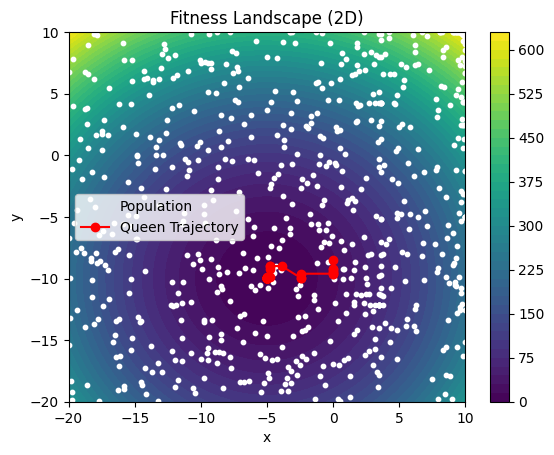

In [77]:
def visualize_2d_evolution(history, population, fitness_func, lower_bound=-20, upper_bound=10):
    # Plot queen fitness over iterations
    plt.figure()
    plt.plot(history["iteration"], history["queen_fitness"], marker='o')
    plt.title("Queen Fitness over Iterations (2D)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.grid(True)
    
    # Create a contour plot of the fitness landscape
    x_range = np.linspace(lower_bound, upper_bound, 200)
    y_range = np.linspace(lower_bound, upper_bound, 200)
    X, Y = np.meshgrid(x_range, y_range)
    # Here we assume the simple_2d_circle uses the same bounds.
    Z = (X + 5)**2 + (Y + 10)**2
    plt.figure()
    cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.title("Fitness Landscape (2D)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(lower_bound, upper_bound)
    plt.ylim(lower_bound, upper_bound)
    
    # Overlay the final population positions
    population_points = [decode_multidim_scaled(indiv, 2, lower_bound, upper_bound) for indiv in population]
    pop_x = [point[0] for point in population_points]
    pop_y = [point[1] for point in population_points]
    plt.scatter(pop_x, pop_y, color='white', s=10, label="Population")
    
    # Plot the queen's trajectory from history
    queen_x = [q[0] for q in history["queen_value"]]
    queen_y = [q[1] for q in history["queen_value"]]
    plt.plot(queen_x, queen_y, color='red', marker='o', label="Queen Trajectory")
    plt.legend()
    
    plt.show()
    
visualize_2d_evolution(history_2d, population_2d, simple_2d_circle, lower_bound=-20, upper_bound=10)
